In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torchvision.transforms.functional as F

from PIL import Image, ImageOps
import numpy as np

In [3]:
# trainset = torchvision.datasets.ImageFolder(root=output, transform=transform)
# transforms.ToPILImage(),
class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """
    
    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        if not F._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            rgb = Image.merge('RGB', (r, g, b))
            inv = ImageOps.invert(rgb)
            r, g, b = inv.split()
            inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [49]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                 Invert(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

In [50]:
trainset = datasets.MNIST('MNIST_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_TESTSET', download=True, train=False, transform=transform)
# trainset = torchvision.datasets.ImageFolder(root='DATA_COMPUTED', transform=transform)
# valset = torchvision.datasets.ImageFolder(root='TESTING', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [51]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


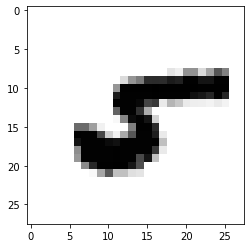

In [52]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

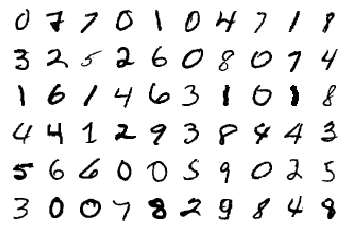

In [53]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [9]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [15]:
model.load_state_dict('model_v1.pt')

AttributeError: 'str' object has no attribute 'copy'

In [10]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [11]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0054,  0.0054,  0.0054,  ...,  0.0054,  0.0054,  0.0054],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        [ 0.0016,  0.0016,  0.0016,  ...,  0.0016,  0.0016,  0.0016],
        ...,
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [ 0.0033,  0.0033,  0.0033,  ...,  0.0033,  0.0033,  0.0033],
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011]])


In [65]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
time0 = time()
epochs = 100
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)
        
torch.save(model, 'model_sudoku.pt')

Epoch 0 - Training loss: 0.00479265337344259

Training Time (in minutes) = 0.025942134857177734
Epoch 1 - Training loss: 0.0047041991278284085

Training Time (in minutes) = 0.05185557206471761
Epoch 2 - Training loss: 0.004420846814020096

Training Time (in minutes) = 0.08023319244384766
Epoch 3 - Training loss: 0.004246440431176636

Training Time (in minutes) = 0.10610899527867636
Epoch 4 - Training loss: 0.004073989255917503

Training Time (in minutes) = 0.13173505067825317
Epoch 5 - Training loss: 0.003957131908177153

Training Time (in minutes) = 0.15724786122639975
Epoch 6 - Training loss: 0.00368636550449178

Training Time (in minutes) = 0.18259338935216268
Epoch 7 - Training loss: 0.003613425934944596

Training Time (in minutes) = 0.20839861631393433
Epoch 8 - Training loss: 0.003411987065766497

Training Time (in minutes) = 0.23412628173828126
Epoch 9 - Training loss: 0.0032429452250270466

Training Time (in minutes) = 0.2605457981427511
Epoch 10 - Training loss: 0.003174004619

KeyboardInterrupt: 

In [12]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

torch.FloatTensor
Predicted Digit = 0


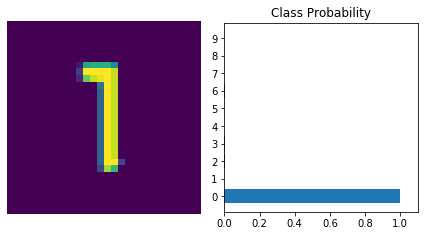

In [17]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
print(img.type())

model = torch.load('model_font.pt')
model.eval()

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

view_classify(img.view(1, 28, 28), ps)

In [14]:
img = Image.open('erode.png')
img = img.convert('L')
img = np.array(img.getdata())
img = img/255
img[img>0.4] = -1.0000
img[img>-1] = 0

# kernel = np.ones((1,1),np.uint8)
# img = cv2.erode(img,kernel,iterations = 1)

img = np.array([img])
img = torchvision.transforms.ToTensor()(img)
img = img.type(torch.FloatTensor).view(1, 784)

FileNotFoundError: [Errno 2] No such file or directory: 'erode.png'

In [19]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)


        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 298

Model Accuracy = 0.9362416107382551


In [ ]:
def shift(OldMin, OldMax, NewMin, NewMax):
    return lambda x: (((x - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin

def mean(l):
    return sum(l)/len(l)